Explore data from the test run on Talapas. Namely, is excess kurtosis a reliable sign of differences between Gaussian and power law dispersal?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('summary_testruns.csv')
df.head()

,seed,PL_dispersal,capacity,habitat_width,sigma,kernel_exponent,mean_distance,sd_distance,max_distance,excess_kurtosis
0,28240,False,10,50,0.2,1,0.31514,0.136993,0.998409,0.541625
1,52243,False,10,50,2.0,1,2.93477,1.327300,9.416730,0.398566
2,33897,False,10,50,2.0,1,2.92012,1.319400,10.330300,0.568407
3,38015,False,10,50,2.0,1,2.93816,1.325500,11.297000,0.494876
4,9995,False,10,50,2.0,1,2.92811,1.333910,9.942380,0.518232


Each row is a summary from the final generation of short simulations. I ran these until `maxgens = 50` generations -- just enough to be pretty sure there's no one still alive from the initial generation. This gave what is assumed to be a representative sample of what dispersal distances would look like at any arbitrary time during longer simulations. I recorded landscape- and dispersal-related simulation parameters, computed some statistics related to the actualized dispersal distances of everyone alive in the final generation, and wrote everything to a log file at the end of simulations.

In [3]:
len(df)

600

In [4]:
df.value_counts(['PL_dispersal', 'sigma', 'kernel_exponent'])

PL_dispersal  sigma  kernel_exponent
False         0.2    1                  100
              2.0    1                  100
True          0.2    1                  100
                     5                  100
              2.0    1                  100
                     5                  100
dtype: int64

100 samples each with Gaussian kernels having high and low sigma, then 100 samples each with broad and narrow PL kernels and each of the high and low sigma values. 

I sought to explore the edges of parameter space for these simulations. We previously discussed using sigma values between 0.2 and 2 for training models using the disperseNN architecture. That seems good to me, and populations consistently do not go extinct at those values (with $K=10$, $W=50$, and short simulations). I also used both of those extreme sigma values in simulations with power law dispersal by broad (kernel_exponent = 1) and narrow (kernel_exponent = 5) jump kernels.

So what does the kurtosis look like in Gaussian simulations?

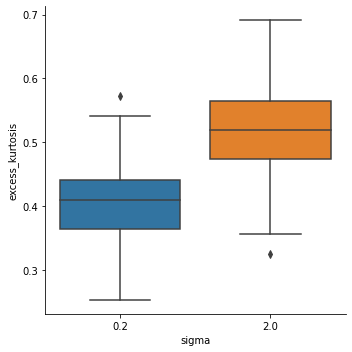

In [5]:
norm_sel = ~df.PL_dispersal
g = sns.catplot(data=df[norm_sel], x='sigma', y='excess_kurtosis', kind='box');

Excess kurtosis values are reliably less than one with Gaussian jump kernels, with some apparent dependence on the width of the kernel.

How about results with PL jump kernels?

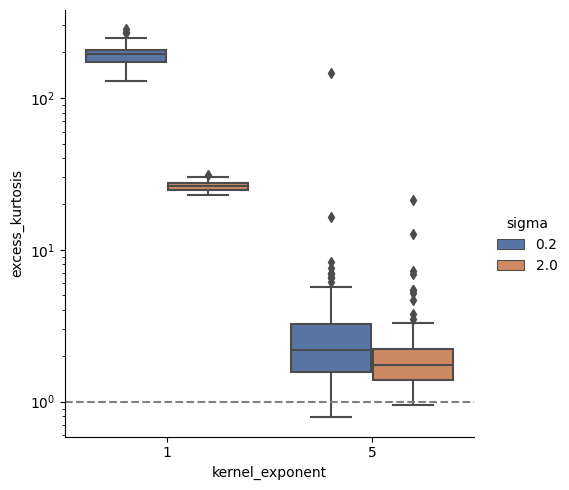

In [8]:
g = sns.catplot(data=df[df.PL_dispersal], x='kernel_exponent', hue='sigma', palette='deep', y='excess_kurtosis', kind='box');
g.ax.set_yscale('log')
g.refline(y=1)

Consistently much greater than one with the broad jump kernels, but also almost always greater than one with the narrow jump kernels with kernel_exponent = 5. That's somewhat surprising because those populations should have *almost* all short-range dispersal, and the LDD events shouldn't be very long due to the narrow power law tail. The dynamics of those populations during range expansions look just like populations with Gaussian dispersal. 

Sample from the PL jump kernel. Do we observe significant outliers with narrow kernels?

In [44]:
def sample_jk(exponent, sigma, N_samples=1e6, hist=False):
    A = exponent / (exponent + 1)

    Xvals = np.random.uniform(size=int(N_samples))
    unif = Xvals <= A

    distances = np.zeros_like(Xvals)
    distances[unif] = Xvals[unif] * sigma / A
    distances[~unif] = (sigma**(-exponent) * (A + A*exponent - Xvals[~unif]*exponent) / A)**(-1/exponent)
    
    if hist: 
        plt.hist(distances/sigma, bins=50, range=(0, 5), density=True) 
        plt.xlabel(r'rescaled dispersal distance $r/\sigma$')
    
    return distances

mean distance: 0.62
std distance: 0.40
longest few: 5.06 4.33 4.18 4.10 3.69


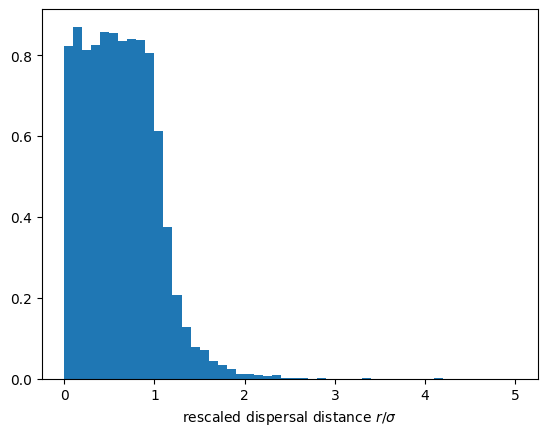

In [54]:
draws = sample_jk(5, 1, N_samples=20000, hist=True)
print(f'mean distance: {np.mean(draws):.2f}')
print(f'std distance: {np.std(draws):.2f}')
print('longest few:', *[f'{d:.2f}' for d in np.sort(draws)[-1:-6:-1]])

Yes, maybe there would be enough draws significantly above the mean to cause a signal in the excess kurtosis.

Make a nice plot with everything together:

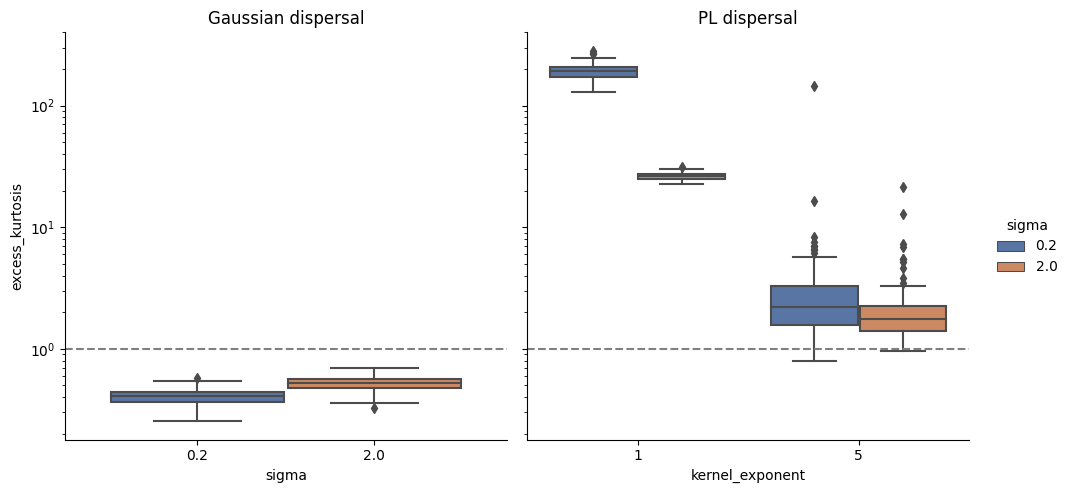

In [25]:
g = sns.catplot(data=df, x='kernel_exponent', y='excess_kurtosis', hue='sigma', palette='deep', col='PL_dispersal', kind='box', sharex=False);
[ax.set_yscale('log') for ax in g.axes.flatten()]
g.refline(y=1)
g.axes[0, 0].set_xticks([-0.2, 0.2], labels=['0.2', '2.0'])
g.axes[0, 0].set_xlabel('sigma')
[ax.set_title(t) for ax, t in zip(g.axes.flatten(), ['Gaussian dispersal', 'PL dispersal'])];

**Possible directions** 

The dashed line at excess_kurtosis = 1 does a reasonably good job separating Gaussian from PL dispersal. The dynamics in populations with kernel_exponent = 5 should look just like populations with Gaussian dispersal, so it's somewhat surprising/concerning that those two data sets are on opposite sides of this proposed division. Nevertheless, I propose we train a model to predict three outputs:

- mean dispersal distance

- SD dispersal distance

- yes/no LDD, where the training label is determined as yes/no excess kurtosis > 1 from dispersal distances of everyone alive in final generation of simulations

This would lead to the populations with the narrow PL jump kernels being classified as yes LDD. **Downstream possibility**: train a second network using the disperseNN architecture to estimate the kernel exponent for populations classified as yes LDD. Maybe that could detect the narrowness of the jump kernel?

So I'm proposing we run a bunch of simulations to hopefully get a proof of concept showing that this all works. Run simulations with:

- Gaussian dispersal with sigma between 0.2 and 2

- Power law dispersal with kernel exponents between 1 and 5 and sigma between 0.2 and 2

And fix the following parameters:

- $K=10$

- $W=50$

- `maxgens = 1e5`

Record the following from each simulation:

- tree sequences, to be used as input for the CNN

- log file from final generation, as above, to provide training labels

Proposed immediate next steps:

- Get those simulations going. How many do we need? A few hundred each with Gaussian and PL dispersal?

- Begin adapting disperseNN architecture to have multiple outputs. This should be simple? Maybe want to carefully consider the activation function for the yes/no LDD output stream so we can interpret it as a probability of yes LDD.